In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from matplotlib import pyplot
import seaborn as sns

from sklearn.model_selection import ParameterGrid

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import gc
import json
pd.set_option('display.max_columns', 1000)
import tensorflow as tf
import category_encoders as ce

import random
import copy
pd.set_option('display.max_columns', 1000)

/kaggle/input/data-science-bowl-2019/test.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/train.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/sample_submission.csv


In [2]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [3]:
def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

In [4]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [5]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    
    train['type_world'] = list(map(lambda x, y: str(x) + '_' + str(y), train['type'], train['world']))
    test['type_world'] = list(map(lambda x, y: str(x) + '_' + str(y), test['type'], test['world']))
    all_type_world = list(set(train["type_world"].unique()).union(test["type_world"].unique()))
    
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code, activities_map, all_type_world

In [6]:
def cnt_miss(df):
    cnt = 0
    for e in range(len(df)):
        x = df['event_data'].iloc[e]
        y = json.loads(x)['misses']
        cnt += y
    return cnt

def get_4020_acc(df,counter_dict):
    
    for e in ['Cauldron Filler (Assessment)', 'Bird Measurer (Assessment)', 
              'Mushroom Sorter (Assessment)','Chest Sorter (Assessment)']:
        
        Assess_4020 = df[(df.event_code == 4020) & (df.title==activities_map[e])]   
        true_attempts_ = Assess_4020['event_data'].str.contains('true').sum()
        false_attempts_ = Assess_4020['event_data'].str.contains('false').sum()

        measure_assess_accuracy_ = true_attempts_/(true_attempts_+false_attempts_) if (true_attempts_+false_attempts_) != 0 else 0
        counter_dict[e+"_4020_accuracy"] += (counter_dict[e+"_4020_accuracy"] + measure_assess_accuracy_) / 2.0
    
    return counter_dict

def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    assess_4020_acc_dict = {'Cauldron Filler (Assessment)_4020_accuracy': 0, 
                            'Mushroom Sorter (Assessment)_4020_accuracy': 0, 
                            'Bird Measurer (Assessment)_4020_accuracy': 0, 
                            'Chest Sorter (Assessment)_4020_accuracy': 0}
    
    game_time_dict = {'Clip_gametime': 0, 'Game_gametime': 0, 
                      'Activity_gametime': 0, 'Assessment_gametime': 0}
    
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    
    # Newly added features
    accumulated_game_miss = 0
    Cauldron_Filler_4025 = 0
    mean_game_round = 0
    mean_game_duration = 0 
    mean_game_level = 0
    Assessment_mean_event_count = 0
    Game_mean_event_count = 0
    Activity_mean_event_count = 0
    chest_assessment_uncorrect_sum = 0
    
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    durations_game = []
    durations_activity = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    last_game_time_title = {'lgt_' + title: 0 for title in assess_titles}
    ac_game_time_title = {'agt_' + title: 0 for title in assess_titles}
    ac_true_attempts_title = {'ata_' + title: 0 for title in assess_titles}
    ac_false_attempts_title = {'afa_' + title: 0 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
    type_world_count: Dict[str, int] = {w_eve: 0 for w_eve in all_type_world}
    session_count = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
        
        if session_type == "Activity":
            Activity_mean_event_count = (Activity_mean_event_count + session['event_count'].iloc[-1])/2.0
            
        if session_type == "Game":
            Game_mean_event_count = (Game_mean_event_count + session['event_count'].iloc[-1])/2.0
            
            game_s = session[session.event_code == 2030]
            misses_cnt = cnt_miss(game_s)
            accumulated_game_miss += misses_cnt
            
            try:
                game_round = json.loads(session['event_data'].iloc[-1])["round"]
                mean_game_round =  (mean_game_round + game_round)/ 2.0
            except:
                pass

            try:
                game_duration = json.loads(session['event_data'].iloc[-1])["duration"]
                mean_game_duration = (mean_game_duration + game_duration) / 2.0
            except:
                pass
            
            try:
                game_level = json.loads(session['event_data'].iloc[-1])["level"]
                mean_game_level = (mean_game_level + game_level) / 2.0
            except:
                pass
                    
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(title_count.copy())
            features.update(game_time_dict.copy())
            features.update(event_id_count.copy())
            features.update(title_event_code_count.copy())
            features.update(assess_4020_acc_dict.copy())
            features.update(type_world_count.copy())
            features.update(last_game_time_title.copy())
            features.update(ac_game_time_title.copy())
            features.update(ac_true_attempts_title.copy())
            features.update(ac_false_attempts_title.copy())
            features['installation_session_count'] = session_count
            
            features['accumulated_game_miss'] = accumulated_game_miss
            features['mean_game_round'] = mean_game_round
            features['mean_game_duration'] = mean_game_duration
            features['mean_game_level'] = mean_game_level
            features['Assessment_mean_event_count'] = Assessment_mean_event_count
            features['Game_mean_event_count'] = Game_mean_event_count
            features['Activity_mean_event_count'] = Activity_mean_event_count
            features['chest_assessment_uncorrect_sum'] = chest_assessment_uncorrect_sum
            
            
            
            
            variety_features = [('var_event_code', event_code_count), 
                                ('var_event_id', event_id_count), 
                                ('var_title', title_count), 
                                ('var_title_event_code', title_event_code_count), 
                                ('var_type_world', type_world_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            
            # ----------------------------------------------
            ac_true_attempts_title['ata_' + session_title_text] += true_attempts
            ac_false_attempts_title['afa_' + session_title_text] += false_attempts
            
            
            last_game_time_title['lgt_' + session_title_text] = session['game_time'].iloc[-1]
            ac_game_time_title['agt_' + session_title_text] += session['game_time'].iloc[-1]
            # ----------------------------------------------
            
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
                features['last_duration'] = 0
                features['duration_max'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
                features['last_duration'] = durations[-1]
                features['duration_max'] = np.max(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            
            if durations_game == []:
                features['duration_game_mean'] = 0
                features['duration_game_std'] = 0
                features['game_last_duration'] = 0
                features['game_max_duration'] = 0
            else:
                features['duration_game_mean'] = np.mean(durations_game)
                features['duration_game_std'] = np.std(durations_game)
                features['game_last_duration'] = durations_game[-1]
                features['game_max_duration'] = np.max(durations_game)
                
            if durations_activity == []:
                features['duration_activity_mean'] = 0
                features['duration_activity_std'] = 0
                features['game_activity_duration'] = 0
                features['game_activity_max'] = 0
            else:
                features['duration_activity_mean'] = np.mean(durations_activity)
                features['duration_activity_std'] = np.std(durations_activity)
                features['game_activity_duration'] = durations_activity[-1]
                features['game_activity_max'] = np.max(durations_activity)
            
            # the accuracy is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            # --------------------------
            features['Cauldron_Filler_4025'] = Cauldron_Filler_4025/counter if counter > 0 else 0
            Assess_4025 = session[(session.event_code == 4025) & (session.title=='Cauldron Filler (Assessment)')]
            true_attempts_ = Assess_4025['event_data'].str.contains('true').sum()
            false_attempts_ = Assess_4025['event_data'].str.contains('false').sum()

            cau_assess_accuracy_ = true_attempts_/(true_attempts_+false_attempts_) if (true_attempts_+false_attempts_) != 0 else 0
            Cauldron_Filler_4025 += cau_assess_accuracy_
            
            chest_assessment_uncorrect_sum += len(session[session.event_id=="df4fe8b6"])
            
            Assessment_mean_event_count = (Assessment_mean_event_count + session['event_count'].iloc[-1])/2.0
            # ----------------------------
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
            
        if session_type == 'Game':
            durations_game.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            
        if session_type == 'Activity':
            durations_activity.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
                
        
        session_count += 1
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')
        type_world_count = update_counters(type_world_count, 'type_world')
        
        assess_4020_acc_dict = get_4020_acc(session , assess_4020_acc_dict)
        game_time_dict[session_type+'_gametime'] = (game_time_dict[session_type+'_gametime'] + (session['game_time'].iloc[-1]/1000.0))/2.0

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [7]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

In [8]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, params, categoricals=[], n_splits=5, verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = params
        self.y_pred, self.score, self.model, self.oof_pred = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = GroupKFold(n_splits=self.n_splits)
        return cv.split(self.train_df, groups=self.train_df['installation_id'])
            
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print("------------------------------------------")
            print('Our oof cohen kappa score is: ', loss_score)
            print("------------------------------------------")
        return y_pred, loss_score, model, oof_pred

In [9]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        

In [10]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, train_set, 
                         num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=verbosity, early_stopping_rounds=200)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)

In [11]:
# NN
Dropout_par = 0.2
learning_rate_nn = 4e-4
epochs_nn = 100
n_splits_nn = 5

class Nn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, params, categoricals=[], n_splits=n_splits_nn, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                ce_ohe = ce.OneHotEncoder(cols=categoricals, handle_unknown='impute')
                train_df = ce_ohe.fit_transform(train_df)
                test_df = ce_ohe.fit_transform(test_df)
        features_cat = [col for col in list(train_df.columns) if col in "session_title"]
        features_cat.extend(features)
        features_cat.remove("session_title")
        features_cat.remove("installation_id")
        
        scalar = MinMaxScaler()
        train_df[features_cat] = scalar.fit_transform(train_df[features_cat])
        test_df[features_cat] = scalar.transform(test_df[features_cat])
        print(train_df[features_cat].shape)
        
        features_cat.append("installation_id")
        super().__init__(train_df, test_df, features_cat, params, categoricals, n_splits, verbose)
        
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(train_set['X'].shape[1],)),
#            tf.keras.layers.Dense(200, activation='relu'),
#            tf.keras.layers.LayerNormalization(),
#            tf.keras.layers.Dropout(Dropout_par),
            tf.keras.layers.Dense(500, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(Dropout_par),
#            tf.keras.layers.Dense(50, activation='relu'),
#            tf.keras.layers.LayerNormalization(),
#            tf.keras.layers.Dropout(Dropout_par),
            tf.keras.layers.Dense(25, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(Dropout_par),
            tf.keras.layers.Dense(1, activation='relu')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_nn), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=epochs_nn,
                callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set

In [12]:
# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code, activities_map, all_type_world = encode_title(train, test, train_labels)

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


In [13]:
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [14]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [15]:
useful_features = ['91561152', '3bb91ced', '6f8106d9', 'Costume Box', 'ecaab346', '6f4bd64e', 'f32856e4', '3b2048ee', '6f4adc4b', '45d01abe', 'Balancing Act', '46b50ba8', '6d90d394', '47efca07', 'f6947f54', '6f445b57', '3afde5dd', 'Dino Drink', '3a4be871', 'fd20ea40', 'e9c52111', '2dc29e21', '8d84fa81', '30614231', '30df3273', '33505eae', '3393b68b', '363c86c9', '7040c096', '36fa3ebe', '37937459', '37db1c2f', '38074c54', '804ee27f', '48349b14', '4901243f', 'f7e47413', '4a09ace1', '5be391b5', '99ea62f3', '99abe2bb', '9554a50b', '93edfe2e', '5e3ea25a', '92687c59', '90efca10', '5f5b2617', '6043a2b4', '6077cc36', '6088b756', '63f13dd7', '65abac75', '5a848010', '2a444e03', '598f4598', '9b01374f', 'f806dc10', '4bb2f698', '4c2ec19f', '4d6737eb', '4e5fc6f5', 'All Star Sorting', 'f93fc684', '51311d7a', '6cf7d25c', '9e6b7fb5', '53c6e11a', '6c517a88', '9d4e7b25', '56817e2b', '9c5ef70c', '58a0de5c', '67aa2ada', '29f54413', '28f975ea', 'c7f7f0e1', '87d743c1', 'c54cf6c5', 4031, 'c2baf0bd', 'c1cac9a2', 'ca11f653', '7961e599', 'bd701df8', 4080, '89aace00', 'b7dc8128', '792530f8', '8ac7cce4', 4050, 'cb1178ad', 'cc5087a3', 'cf7638f3', 'dcb55a27', '7f0836bf', 3, 'd9c005dd', 'd88ca108', 'd51b1749', '857f21c0', '85d1b0de', 'd2e9262e', 'd2659ab4', 2070, 2075, 'd185d3ea', '7d5c30a2', '86c924c4', '29bdd9ba', 'ata_Cauldron Filler (Assessment)', 'ata_Mushroom Sorter (Assessment)', '0086365d', '15ba1109', '74e5f8a7', '16667cc5', '16dffff1', '7423acbc', '19967db1', '1af8be29', '8d748b58', '1beb320a', '1cc7cfca', '1cf54632', '736f9581', 'e7e44842', '26a5a3dd', 'a5be6304', '8af75982', '1575e76c', '14de4c5d', '00c73085', 'afa_Cart Balancer (Assessment)', '8b757ab8', 'e080a381', 'e3ff61fb', '05ad839b', '06372577', '070a5291', '08ff79ad', 'e64e2cfd', '763fc34e', '12 Monkeys', '756e5507', 'mean_game_level', '90ea0bac', '86ba578b', '88d4a5be', '8fee50e2', '9de5e594', 'db02c830', 'd38c2fd7', 'd3640339', 'd2278a3b', 'd122731b', 'cfbd47c8', 'c6971acf', 'c58186bf', 'c189aaf2', 'bc8f2793', 'b5053438', 'b120f2ac', 'duration_game_mean', 'acf5c23f', 'ab3136ba', 'a5e9da97', 'a2df0760', 'a1e4395d', 'Watering Hole (Activity)', 'Treasure Map', 'Ordering Spheres', 'Lifting Heavy Things', 'Honey Cake', 'Crystal Caves - Level 1', 'ecc36b7f', 'Bubble Bath', 'Bottle Filler (Activity)', 'f50fc6c1', '9ee1c98c', 'fbaf3456', '84538528', '7ec0c298', '28ed704e', '47f43a44', '3dcdda7f', '56cd3b43', '828e68f9', '5c3d2b2f', '5de79a6a', '262136f4', 'game_activity_duration', '0d1da71f', '0330ab6a', '02a42007', '15eb4a7d', 2081, 1, '7ad3efc6', 4010, '4ef8cdd3', 4022, '499edb7c', 'e7561dd2', '3ddc79c3', 'Chow Time', 2, '3d63345e', '3afb49e6', 'Flower Waterer (Activity)', 'Leaf Leader', '2c4e6db0', '2b058fe3', 'bdf49a58', 'a7640a16', 'd02b7a8e', 'Scrub-A-Dub', '15a43e5b', '25fa8af4', 2035, 4095, '84b0e0c8', '90d848e0', '56bcd38d', '795e4a37', 'df4940d3', '77261ab5', '5e109ec3', '9ed8f6da', '7dfe6d8a', 'fcfdffb6', '532a2afb', '5e812b27', 'c952eb01', 4021, 'Pan Balance', 'var_event_code', 'c0415e5c', 'Game_MAGMAPEAK', 'a1bbe385', '69fdac0a', 4090, 'a8876db3', '907a054b', 4220, 'agt_Cauldron Filler (Assessment)', '7372e1a5', '1bb5fbdb', '392e14df', '2dcad279', 'Dino Dive', 'de26c3a6', 2050, 'd3f1e122', '3d8c61b0', 2020, 'Tree Top City - Level 1', 'a0faea5d', 'session_title', 'Sandcastle Builder (Activity)', '46cd75b4', 'b1d5101d', 'Clip_TREETOPCITY', 'game_max_duration', 'agt_Cart Balancer (Assessment)', 'Activity_MAGMAPEAK', '4a4c3d21', 'a44b10dc', '461eace6', 'Activity_gametime', 'accumulated_correct_attempts', 'Crystals Rule', 4230, 4045, '022b4259', 'f54238ee', 'Bird Measurer (Assessment)', '1325467d', 'Rulers', 'e694a35b', 'Chicken Balancer (Activity)', '5c2f29ca', 2080, '7d093bf9', '7ab78247', 'accumulated_actions', 'Game_gametime', 3121, 2083, '6bf9e3e1', 'b88f38da', 4110, '9e34ea74', 'Tree Top City - Level 2', 2060, '587b5989', 'Heavy, Heavier, Heaviest', 'Game_mean_event_count', 'cdd22e43', 'Egg Dropper (Activity)', 'd88e8f25', '7da34a02', 'c7128948', 'var_event_id', '884228c8', 'bcceccc6', 4040, 'Activity_mean_event_count', 'duration_game_std', '76babcde', 'Mushroom Sorter (Assessment)', 'ec138c1c', 'lgt_Cart Balancer (Assessment)', 'e79f3763', 'Clip_CRYSTALCAVES', 'Cart Balancer (Assessment)', 2000, 'duration_activity_std', 'cf82af56', 3120, 'Happy Camel', '51102b85', 'Welcome to Lost Lagoon!', 2025, 'Game_CRYSTALCAVES', 4020, '93b353f2', 'lgt_Cauldron Filler (Assessment)', '0db6d71d', '71fe8f75', 'var_title', 2010, 'Bug Measurer (Activity)', 'accumulated_accuracy', 'mean_game_round', 4030, 'a76029ee', 4035, 'Magma Peak - Level 1', 'game_last_duration', 'Game_TREETOPCITY', 4070, '04df9b66', '3edf6747', 'Tree Top City - Level 3', 'Activity', 'Activity_CRYSTALCAVES', 'accumulated_game_miss', 'bd612267', 'game_activity_max', 'a16a373e', '3ee399c3', 'duration_activity_mean', 'lgt_Mushroom Sorter (Assessment)', 'var_type_world', '363d3849', 'agt_Chest Sorter (Assessment)', 4025, 'Cauldron Filler (Assessment)', 'Activity_TREETOPCITY', '3d0b9317', '5348fd84', 'a8efe47b', 'Crystal Caves - Level 2', 'lgt_Bird Measurer (Assessment)', '731c0cbe', 3110, '565a3990', 'Clip_MAGMAPEAK', 'Assessment_TREETOPCITY', '0d18d96c', '5f0eb72c', 'Chest Sorter (Assessment)', 4100, '77c76bc5', 'Assessment_CRYSTALCAVES', 'mean_game_duration', '155f62a4', 'Assessment', 'duration_max', 'afa_Cauldron Filler (Assessment)', '9ce586dd', '562cec5f', 'Slop Problem', 'agt_Bird Measurer (Assessment)', 'f56e0afc', 'Assessment_gametime', '17113b36', 'duration_mean', 'lgt_Chest Sorter (Assessment)', 'duration_std', 'last_duration', 0, 'Clip', 'acc_Chest Sorter (Assessment)', 'acc_Cauldron Filler (Assessment)', 'acc_Mushroom Sorter (Assessment)']

In [16]:
features = [x for x in features if x in useful_features]
reduce_train[features].shape

(17690, 395)

In [17]:
reduce_train_2 = reduce_train.copy()
reduce_test_2 = reduce_test.copy()

In [18]:
reduce_train_2.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train_2.columns]
reduce_test_2.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_test_2.columns]

features_2 = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features]

sabsumple : 0.8  
Our oof cohen kappa score is:  0.590557397397415

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



seed : 1
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.908276	valid_1's rmse: 0.974492
[200]	training's rmse: 0.844168	valid_1's rmse: 0.970349
[300]	training's rmse: 0.793884	valid_1's rmse: 0.970327
[400]	training's rmse: 0.751304	valid_1's rmse: 0.971585
Early stopping, best iteration is:
[258]	training's rmse: 0.81355	valid_1's rmse: 0.969963
Partial score of fold 0 is: 0.6095265990110821
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.907703	valid_1's rmse: 0.992827
[200]	training's rmse: 0.844434	valid_1's rmse: 0.991071
[300]	training's rmse: 0.795263	valid_1's rmse: 0.992431
Early stopping, best iteration is:
[150]	training's rmse: 0.873283	valid_1's rmse: 0.990247
Partial score of fold 1 is: 0.5944330374909099
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.907891	valid_1's rmse: 0.98315
[200]	training's rmse: 0.844771	valid_1's rmse: 0.983325
[300]	training'

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.908795	valid_1's rmse: 0.97343
[200]	training's rmse: 0.843489	valid_1's rmse: 0.970308
[300]	training's rmse: 0.792419	valid_1's rmse: 0.971534
[400]	training's rmse: 0.74922	valid_1's rmse: 0.971695
Early stopping, best iteration is:
[202]	training's rmse: 0.84233	valid_1's rmse: 0.970183
Partial score of fold 0 is: 0.6079208139487562
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.90842	valid_1's rmse: 0.993368
[200]	training's rmse: 0.846029	valid_1's rmse: 0.990257
[300]	training's rmse: 0.7958	valid_1's rmse: 0.991024
[400]	training's rmse: 0.753238	valid_1's rmse: 0.990944
[500]	training's rmse: 0.715874	valid_1's rmse: 0.993912
Early stopping, best iteration is:
[329]	training's rmse: 0.782596	valid_1's rmse: 0.989788
Partial score of fold 1 is: 0.5987077880838911
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.9083

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.907587	valid_1's rmse: 0.976516
[200]	training's rmse: 0.84285	valid_1's rmse: 0.972287
[300]	training's rmse: 0.792307	valid_1's rmse: 0.972292
[400]	training's rmse: 0.750208	valid_1's rmse: 0.972427
[500]	training's rmse: 0.712585	valid_1's rmse: 0.975999
Early stopping, best iteration is:
[333]	training's rmse: 0.778093	valid_1's rmse: 0.971408
Partial score of fold 0 is: 0.6129165896982145
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.906762	valid_1's rmse: 0.997215
[200]	training's rmse: 0.843456	valid_1's rmse: 0.993309
[300]	training's rmse: 0.7933	valid_1's rmse: 0.993899
Early stopping, best iteration is:
[175]	training's rmse: 0.857227	valid_1's rmse: 0.992582
Partial score of fold 1 is: 0.5921175475863785
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.906811	valid_1's rmse: 0.98248
[200]	training's rmse: 0.84

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.907613	valid_1's rmse: 0.978213
[200]	training's rmse: 0.842651	valid_1's rmse: 0.974635
[300]	training's rmse: 0.792624	valid_1's rmse: 0.973558
[400]	training's rmse: 0.749186	valid_1's rmse: 0.973698
Early stopping, best iteration is:
[250]	training's rmse: 0.816514	valid_1's rmse: 0.972786
Partial score of fold 0 is: 0.611132384073408
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.907529	valid_1's rmse: 0.995436
[200]	training's rmse: 0.844845	valid_1's rmse: 0.991406
[300]	training's rmse: 0.795632	valid_1's rmse: 0.991029
[400]	training's rmse: 0.754154	valid_1's rmse: 0.994211
Early stopping, best iteration is:
[242]	training's rmse: 0.822629	valid_1's rmse: 0.990379
Partial score of fold 1 is: 0.5917613183702967
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.908657	valid_1's rmse: 0.982437
[200]	training's rmse: 0

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.909293	valid_1's rmse: 0.979374
[200]	training's rmse: 0.843599	valid_1's rmse: 0.972554
[300]	training's rmse: 0.792994	valid_1's rmse: 0.971255
[400]	training's rmse: 0.750785	valid_1's rmse: 0.973261
Early stopping, best iteration is:
[288]	training's rmse: 0.798738	valid_1's rmse: 0.97072
Partial score of fold 0 is: 0.6080992345112368
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.907795	valid_1's rmse: 0.994876
[200]	training's rmse: 0.845247	valid_1's rmse: 0.992749
[300]	training's rmse: 0.794874	valid_1's rmse: 0.992291
[400]	training's rmse: 0.752415	valid_1's rmse: 0.995671
Early stopping, best iteration is:
[295]	training's rmse: 0.796996	valid_1's rmse: 0.991917
Partial score of fold 1 is: 0.597282871219564
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.907191	valid_1's rmse: 0.982008
[200]	training's rmse: 0.

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.90793	valid_1's rmse: 0.976735
[200]	training's rmse: 0.843373	valid_1's rmse: 0.972788
[300]	training's rmse: 0.792401	valid_1's rmse: 0.971585
[400]	training's rmse: 0.749815	valid_1's rmse: 0.972248
Early stopping, best iteration is:
[292]	training's rmse: 0.796025	valid_1's rmse: 0.971204
Partial score of fold 0 is: 0.6134518513856566
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.907266	valid_1's rmse: 0.995078
[200]	training's rmse: 0.842481	valid_1's rmse: 0.99213
[300]	training's rmse: 0.793343	valid_1's rmse: 0.993158
[400]	training's rmse: 0.751519	valid_1's rmse: 0.994717
Early stopping, best iteration is:
[209]	training's rmse: 0.837812	valid_1's rmse: 0.991584
Partial score of fold 1 is: 0.5921175475863785
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.907209	valid_1's rmse: 0.983833
[200]	training's rmse: 0.

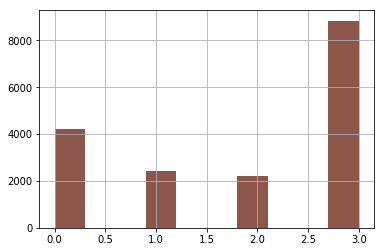

In [19]:
all_params = {'n_estimators':[10000],
              'boosting_type': ['gbdt'],
              'objective': ['regression'],
              'metric': ['rmse'],
              'subsample': [0.8],
              'subsample_freq': [1],
              'learning_rate': [0.05],
              'feature_fraction': [0.9],
              'max_depth': [13],
              "num_leaves":[25],
              'lambda_l1': [1],  
              'lambda_l2': [1],
              'early_stopping_rounds': [200],
              "seed":[1,2,3,4,5,6]
              }


for params in tqdm(list(ParameterGrid(all_params))):
    if params["seed"] == 1:
        print("")
        print("seed : {}".format(params["seed"]))
        lgb_model_1 = Lgb_Model(reduce_train_2, reduce_test_2, features_2, params, categoricals=categoricals)
    
    elif params["seed"] == 2:
        print("")
        print("seed : {}".format(params["seed"]))
        lgb_model_2 = Lgb_Model(reduce_train_2, reduce_test_2, features_2, params, categoricals=categoricals)
        
    elif params["seed"] == 3:
        print("")
        print("seed : {}".format(params["seed"]))
        lgb_model_3 = Lgb_Model(reduce_train_2, reduce_test_2, features_2, params, categoricals=categoricals)
    
    elif params["seed"] == 4:
        print("")
        print("seed : {}".format(params["seed"]))
        lgb_model_4 = Lgb_Model(reduce_train_2, reduce_test_2, features_2, params, categoricals=categoricals)
        
    elif params["seed"] == 5:
        print("")
        print("seed : {}".format(params["seed"]))
        lgb_model_5 = Lgb_Model(reduce_train_2, reduce_test_2, features_2, params, categoricals=categoricals)
    
    elif params["seed"] == 6:
        print("")
        print("seed : {}".format(params["seed"]))
        lgb_model_6 = Lgb_Model(reduce_train_2, reduce_test_2, features_2, params, categoricals=categoricals)

seed:1  
Our oof cohen kappa score is:  0.5913089965805141  
seed:2  
Our oof cohen kappa score is:  0.5916669009534185  
seed:3  
Our oof cohen kappa score is:  0.5894836842787019  
seed:4  
Our oof cohen kappa score is:  0.5925616618856793


# XGB

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



seed : 1


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.80637	val-rmse:1.80421
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.904372	val-rmse:0.982014
[200]	train-rmse:0.852397	val-rmse:0.984107
[300]	train-rmse:0.809466	val-rmse:0.982105
Stopping. Best iteration:
[134]	train-rmse:0.883908	val-rmse:0.981103

Partial score of fold 0 is: 0.5954313745751101
[0]	train-rmse:1.80204	val-rmse:1.81964
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.90739	val-rmse:1.00817
[200]	train-rmse:0.854573	val-rmse:1.00553
[300]	train-rmse:0.813255	val-rmse:1.0082
Stopping. Best iteration:
[150]	train-rmse:0.879597	val-rmse:1.00459

Partial score of fold 1 is: 0.571456253053636
[0]	train-rmse:1.79893	val-rmse:1.83179
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until v

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.80608	val-rmse:1.80372
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.905175	val-rmse:0.981494
[200]	train-rmse:0.854362	val-rmse:0.97891
[300]	train-rmse:0.810297	val-rmse:0.977991
[400]	train-rmse:0.771909	val-rmse:0.978505
[500]	train-rmse:0.73778	val-rmse:0.979557
Stopping. Best iteration:
[330]	train-rmse:0.798459	val-rmse:0.97694

Partial score of fold 0 is: 0.5993566269496846
[0]	train-rmse:1.80197	val-rmse:1.82034
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.907424	val-rmse:1.00492
[200]	train-rmse:0.858299	val-rmse:1.0043
[300]	train-rmse:0.816078	val-rmse:1.00772
[400]	train-rmse:0.779741	val-rmse:1.00968
Stopping. Best iteration:
[222]	train-rmse:0.848339	val-rmse:1.00402

Partial score of fold 1 is: 0.5759091182546581
[0]	train-rms

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.80653	val-rmse:1.80419
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.907499	val-rmse:0.981582
[200]	train-rmse:0.856913	val-rmse:0.980063
[300]	train-rmse:0.813712	val-rmse:0.978536
[400]	train-rmse:0.777091	val-rmse:0.979309
[500]	train-rmse:0.744455	val-rmse:0.980475
Stopping. Best iteration:
[323]	train-rmse:0.80501	val-rmse:0.977847

Partial score of fold 0 is: 0.5948961128876682
[0]	train-rmse:1.80226	val-rmse:1.82086
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.908229	val-rmse:1.00733
[200]	train-rmse:0.858356	val-rmse:1.00646
[300]	train-rmse:0.817002	val-rmse:1.00969
Stopping. Best iteration:
[154]	train-rmse:0.88031	val-rmse:1.00499

Partial score of fold 1 is: 0.5696751069732272
[0]	train-rmse:1.79909	val-rmse:1.83221
Multiple eval 

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:1.80611	val-rmse:1.80371
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.906614	val-rmse:0.981307
[200]	train-rmse:0.853197	val-rmse:0.979677
[300]	train-rmse:0.812704	val-rmse:0.978783
[400]	train-rmse:0.777399	val-rmse:0.977477
[500]	train-rmse:0.742589	val-rmse:0.980742
[600]	train-rmse:0.713107	val-rmse:0.982761
Stopping. Best iteration:
[414]	train-rmse:0.772323	val-rmse:0.977384

Partial score of fold 0 is: 0.600248729762088
[0]	train-rmse:1.80196	val-rmse:1.82173
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.908319	val-rmse:1.00943
[200]	train-rmse:0.855396	val-rmse:1.0052
[300]	train-rmse:0.815763	val-rmse:1.00892
Stopping. Best iteration:
[187]	train-rmse:0.861142	val-rmse:1.00464

Partial score of fold 1 is: 0.5691407631491046
[0]	train-

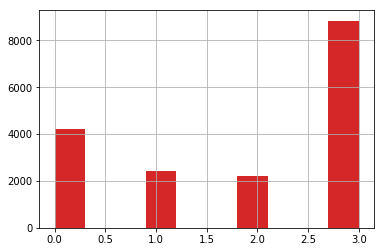

In [20]:
all_params = {'n_estimators':[10000],
              'objective': ['reg:squarederror'],
              'subsample': [1.0],
              'colsample_bytree': [0.8],
              "alpha":[1e-5],
              'learning_rate': [0.05],
              'max_depth': [5],
              "min_child_weight":[2],
              'gamma': [0],  
              "seed":[1,2,3,4]
              }


for params in tqdm(list(ParameterGrid(all_params))):
    if params["seed"] == 1:
        print("")
        print("seed : {}".format(params["seed"]))
        xgb_model_1 = Xgb_Model(reduce_train, reduce_test, features, params, categoricals=categoricals)
    
    elif params["seed"] == 2:
        print("")
        print("seed : {}".format(params["seed"]))
        xgb_model_2 = Xgb_Model(reduce_train, reduce_test, features, params, categoricals=categoricals)
    
    elif params["seed"] == 3:
        print("")
        print("seed : {}".format(params["seed"]))
        xgb_model_3 = Xgb_Model(reduce_train, reduce_test, features, params, categoricals=categoricals)
    
    elif params["seed"] == 4:
        print("")
        print("seed : {}".format(params["seed"]))
        xgb_model_4 = Xgb_Model(reduce_train, reduce_test, features, params, categoricals=categoricals)

In [21]:
# not_log_list = ["accuracy_group", "installation_id", "accumulated_accuracy", "var_type_world", "var_title", "var_event_id", "var_event_code", "acc_Cauldron Filler (Assessment)", "acc_Mushroom Sorter (Assessment)", "acc_Chest Sorter (Assessment)"] 

In [22]:
def log_processing(df):
    df_fin = df.copy()
    col_list = list(df.columns)
    for col in col_list:
        tmp_arr = np.zeros(len(df))
        if col not in not_log_list:
            df_1 = df[df[col] > 0]
            idx = list(df_1.index)
            tmp_arr[idx] = np.log(df_1[col][idx])
            df_fin[col] = tmp_arr
    return df_fin

In [23]:
#reduce_train_MLP = log_processing(reduce_train)
#reduce_test_MLP = log_processing(reduce_test)

In [24]:
#nn_model_1 = Nn_Model(reduce_train_MLP, reduce_test_MLP, features, None, categoricals=categoricals)

In [25]:
sta_dic_train = {"lgb_model_1" : lgb_model_1.oof_pred, "lgb_model_2" : lgb_model_2.oof_pred, "lgb_model_3" : lgb_model_3.oof_pred, "lgb_model_4" : lgb_model_4.oof_pred, "lgb_model_5" : lgb_model_5.oof_pred, "lgb_model_6" : lgb_model_6.oof_pred,
                 "xgb_model_1" : xgb_model_1.oof_pred, "xgb_model_2" : xgb_model_2.oof_pred, "xgb_model_3" : xgb_model_3.oof_pred, "xgb_model_4" : xgb_model_4.oof_pred,
                 }

In [26]:
sta_dic_test = {"lgb_model_1" : lgb_model_1.y_pred, "lgb_model_2" : lgb_model_2.y_pred, "lgb_model_3" : lgb_model_3.y_pred, "lgb_model_4" : lgb_model_4.y_pred, "lgb_model_5" : lgb_model_5.y_pred, "lgb_model_6" : lgb_model_6.y_pred,
                "xgb_model_1" : xgb_model_1.y_pred, "xgb_model_2" : xgb_model_2.y_pred, "xgb_model_3" : xgb_model_3.y_pred, "xgb_model_4" : xgb_model_4.y_pred,
                }

In [27]:
df_last_train = pd.DataFrame(sta_dic_train)
df_last_test = pd.DataFrame(sta_dic_test)

In [28]:
df_last_train = pd.concat([df_last_train, reduce_train["accuracy_group"]], axis=1)
df_last_train = pd.concat([df_last_train, reduce_train["installation_id"]], axis=1)

In [29]:
df_last_train.head()

,lgb_model_1,lgb_model_2,lgb_model_3,lgb_model_4,lgb_model_5,lgb_model_6,xgb_model_1,xgb_model_2,xgb_model_3,xgb_model_4,accuracy_group,installation_id
0,2.012860,1.972049,2.072096,1.984307,2.048278,2.111212,1.852673,1.888331,1.947992,2.026082,3,0006a69f
1,1.472093,1.429244,1.561621,1.272464,1.414210,1.539278,1.585107,1.578511,1.583083,1.572589,0,0006a69f
2,2.292412,2.213174,2.195595,2.040035,2.132646,2.282452,2.413389,2.408727,2.241725,2.353086,3,0006a69f
3,2.151324,2.064347,2.135741,2.166153,2.068305,2.122396,2.108690,2.185287,2.022892,2.245072,2,0006a69f
4,1.357718,1.147560,1.135429,1.234942,1.287609,1.169419,1.202398,1.134783,1.080764,1.083439,3,0006a69f


In [30]:
features_last = list(df_last_test.columns)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



seed : 5
Training until validation scores don't improve for 1000 rounds
[100]	training's rmse: 1.01769	valid_1's rmse: 1.01726
[200]	training's rmse: 0.971663	valid_1's rmse: 0.979889
[300]	training's rmse: 0.959011	valid_1's rmse: 0.975384
[400]	training's rmse: 0.952697	valid_1's rmse: 0.97564
[500]	training's rmse: 0.947965	valid_1's rmse: 0.976344
[600]	training's rmse: 0.944291	valid_1's rmse: 0.977093
[700]	training's rmse: 0.940416	valid_1's rmse: 0.978271
[800]	training's rmse: 0.936656	valid_1's rmse: 0.979255
[900]	training's rmse: 0.932972	valid_1's rmse: 0.980323
[1000]	training's rmse: 0.929347	valid_1's rmse: 0.981256
[1100]	training's rmse: 0.925647	valid_1's rmse: 0.982423
[1200]	training's rmse: 0.921952	valid_1's rmse: 0.98345
[1300]	training's rmse: 0.918397	valid_1's rmse: 0.984303
Early stopping, best iteration is:
[344]	training's rmse: 0.956	valid_1's rmse: 0.975134
Partial score of fold 0 is: 0.6009624120120105
Training until validation scores don't improve for

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's rmse: 1.01769	valid_1's rmse: 1.01744
[200]	training's rmse: 0.971729	valid_1's rmse: 0.980027
[300]	training's rmse: 0.959024	valid_1's rmse: 0.975374
[400]	training's rmse: 0.952869	valid_1's rmse: 0.975779
[500]	training's rmse: 0.94846	valid_1's rmse: 0.976723
[600]	training's rmse: 0.944126	valid_1's rmse: 0.978042
[700]	training's rmse: 0.940351	valid_1's rmse: 0.978929
[800]	training's rmse: 0.936382	valid_1's rmse: 0.980055
[900]	training's rmse: 0.932377	valid_1's rmse: 0.98126
[1000]	training's rmse: 0.928608	valid_1's rmse: 0.982443
[1100]	training's rmse: 0.924917	valid_1's rmse: 0.983586
[1200]	training's rmse: 0.921136	valid_1's rmse: 0.984691
[1300]	training's rmse: 0.917699	valid_1's rmse: 0.985731
Early stopping, best iteration is:
[319]	training's rmse: 0.957617	valid_1's rmse: 0.975244
Partial score of fold 0 is: 0.6014976736994525
Training until validation scores don't improve for 1000 rounds
[100]	training's rmse: 1.01377	valid_1's rmse: 1.03538
[2

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's rmse: 1.01769	valid_1's rmse: 1.01681
[200]	training's rmse: 0.971568	valid_1's rmse: 0.979335
[300]	training's rmse: 0.958687	valid_1's rmse: 0.974868
[400]	training's rmse: 0.9524	valid_1's rmse: 0.975486
[500]	training's rmse: 0.947891	valid_1's rmse: 0.976407
[600]	training's rmse: 0.943586	valid_1's rmse: 0.977625
[700]	training's rmse: 0.939503	valid_1's rmse: 0.978701
[800]	training's rmse: 0.935406	valid_1's rmse: 0.9797
[900]	training's rmse: 0.9316	valid_1's rmse: 0.980528
[1000]	training's rmse: 0.927945	valid_1's rmse: 0.981634
[1100]	training's rmse: 0.924567	valid_1's rmse: 0.982644
[1200]	training's rmse: 0.921063	valid_1's rmse: 0.983377
[1300]	training's rmse: 0.917579	valid_1's rmse: 0.984357
Early stopping, best iteration is:
[311]	training's rmse: 0.957851	valid_1's rmse: 0.974829
Partial score of fold 0 is: 0.6016760942619331
Training until validation scores don't improve for 1000 rounds
[100]	training's rmse: 1.01389	valid_1's rmse: 1.03513
[200]	

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's rmse: 1.01766	valid_1's rmse: 1.01689
[200]	training's rmse: 0.971728	valid_1's rmse: 0.979004
[300]	training's rmse: 0.958976	valid_1's rmse: 0.974803
[400]	training's rmse: 0.952728	valid_1's rmse: 0.975211
[500]	training's rmse: 0.947967	valid_1's rmse: 0.97643
[600]	training's rmse: 0.944091	valid_1's rmse: 0.977284
[700]	training's rmse: 0.940253	valid_1's rmse: 0.978124
[800]	training's rmse: 0.936377	valid_1's rmse: 0.979306
[900]	training's rmse: 0.932567	valid_1's rmse: 0.980449
[1000]	training's rmse: 0.928835	valid_1's rmse: 0.981528
[1100]	training's rmse: 0.925168	valid_1's rmse: 0.982546
[1200]	training's rmse: 0.921431	valid_1's rmse: 0.983577
[1300]	training's rmse: 0.917784	valid_1's rmse: 0.984531
Early stopping, best iteration is:
[324]	training's rmse: 0.957177	valid_1's rmse: 0.974615
Partial score of fold 0 is: 0.6004271503245686
Training until validation scores don't improve for 1000 rounds
[100]	training's rmse: 1.0139	valid_1's rmse: 1.03551
[2

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's rmse: 1.01779	valid_1's rmse: 1.01759
[200]	training's rmse: 0.971689	valid_1's rmse: 0.979734
[300]	training's rmse: 0.958986	valid_1's rmse: 0.975302
[400]	training's rmse: 0.952815	valid_1's rmse: 0.975693
[500]	training's rmse: 0.948106	valid_1's rmse: 0.976579
[600]	training's rmse: 0.943924	valid_1's rmse: 0.977772
[700]	training's rmse: 0.939932	valid_1's rmse: 0.978576
[800]	training's rmse: 0.936127	valid_1's rmse: 0.979644
[900]	training's rmse: 0.932232	valid_1's rmse: 0.980884
[1000]	training's rmse: 0.928513	valid_1's rmse: 0.982141
[1100]	training's rmse: 0.924916	valid_1's rmse: 0.983303
[1200]	training's rmse: 0.921547	valid_1's rmse: 0.984311
[1300]	training's rmse: 0.918188	valid_1's rmse: 0.985425
Early stopping, best iteration is:
[306]	training's rmse: 0.958534	valid_1's rmse: 0.97523
Partial score of fold 0 is: 0.6007839914495299
Training until validation scores don't improve for 1000 rounds
[100]	training's rmse: 1.01374	valid_1's rmse: 1.03555
[

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's rmse: 1.01778	valid_1's rmse: 1.01726
[200]	training's rmse: 0.97164	valid_1's rmse: 0.979705
[300]	training's rmse: 0.958896	valid_1's rmse: 0.975381
[400]	training's rmse: 0.952614	valid_1's rmse: 0.975668
[500]	training's rmse: 0.947892	valid_1's rmse: 0.976493
[600]	training's rmse: 0.94367	valid_1's rmse: 0.977469
[700]	training's rmse: 0.939908	valid_1's rmse: 0.978417
[800]	training's rmse: 0.935954	valid_1's rmse: 0.979412
[900]	training's rmse: 0.932255	valid_1's rmse: 0.980521
[1000]	training's rmse: 0.928367	valid_1's rmse: 0.981619
[1100]	training's rmse: 0.92466	valid_1's rmse: 0.982751
[1200]	training's rmse: 0.921133	valid_1's rmse: 0.983771
[1300]	training's rmse: 0.917795	valid_1's rmse: 0.984809
Early stopping, best iteration is:
[334]	training's rmse: 0.956301	valid_1's rmse: 0.97513
Partial score of fold 0 is: 0.5998918886371266
Training until validation scores don't improve for 1000 rounds
[100]	training's rmse: 1.01345	valid_1's rmse: 1.0361
[200]

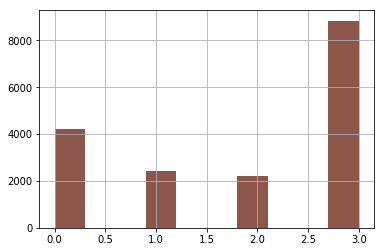

In [31]:
all_params = {'n_estimators':[10000],
              'boosting_type': ['gbdt'],
              'objective': ['regression'],
              'metric': ['rmse'],
              'subsample': [0.8],
              'subsample_freq': [1],
              'learning_rate': [0.01],
              'feature_fraction': [0.9],
              'max_depth': [7],
              "num_leaves":[100],
              "min_data_in_leaf":[100],
              'lambda_l1': [1],  
              'lambda_l2': [1],
              'early_stopping_rounds': [1000],
              "seed":[5,6,7,8,9,10]
              }

for params in tqdm(list(ParameterGrid(all_params))):
    if params["seed"] == 5:
        print("")
        print("seed : {}".format(params["seed"]))
        lgb_model_5 = Lgb_Model(df_last_train, df_last_test, features_last, params, categoricals=None)
    
    elif params["seed"] == 6:
        print("")
        print("seed : {}".format(params["seed"]))
        lgb_model_6 = Lgb_Model(df_last_train, df_last_test, features_last, params, categoricals=None)
        
    elif params["seed"] == 7:
        print("")
        print("seed : {}".format(params["seed"]))
        lgb_model_7 = Lgb_Model(df_last_train, df_last_test, features_last, params, categoricals=None)
    
    elif params["seed"] == 8:
        print("")
        print("seed : {}".format(params["seed"]))
        lgb_model_8 = Lgb_Model(df_last_train, df_last_test, features_last, params, categoricals=None)
        
    elif params["seed"] == 9:
        print("")
        print("seed : {}".format(params["seed"]))
        lgb_model_9 = Lgb_Model(df_last_train, df_last_test, features_last, params, categoricals=None)
    
    elif params["seed"] == 10:
        print("")
        print("seed : {}".format(params["seed"]))
        lgb_model_10 = Lgb_Model(df_last_train, df_last_test, features_last, params, categoricals=None)

In [32]:
lgb_en = (lgb_model_5.y_pred + lgb_model_6.y_pred + lgb_model_7.y_pred + lgb_model_8.y_pred + lgb_model_9.y_pred + lgb_model_10.y_pred) / 6

In [33]:
final_pred = lgb_en
print(final_pred.shape)

(1000,)


{0: 1.4797451786689169, 1: 1.9555568533330714, 2: 2.1862004289249164}


3    0.500
0    0.239
1    0.136
2    0.125
Name: accuracy_group, dtype: float64

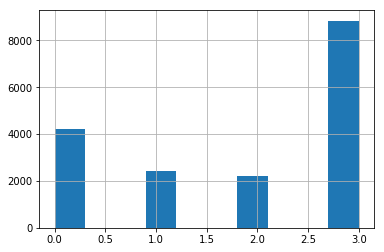

In [34]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)